In [1]:
from graph_ds import PyH3Graph
from pois_to_h3 import get_pois_h3
import pandas as pd
import h3.api.numpy_int as h3
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import seaborn as sns
from ghsl_processing import get_origins, city_boundaries_to_h3 


def plot_hex_df(df, markersize, color_column=None, color_categorical=False):
    df[['y','x']] = list(df['h3_index'].apply(h3.h3_to_geo))
    # Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

    fig, ax = plt.subplots(figsize=(10,10))
    # Show the GeoPandas DataFrame

    if color_column:
        gdf.plot(ax=ax, column=color_column, categorical=color_categorical,
                  legend=True, markersize=markersize, alpha=0.5, cmap='Reds',
                  vmin=0, vmax=25)
    else:
        gdf.plot(ax=ax, markersize=markersize, alpha=0.5)

    #plt.xlim(12.391681,12.737388)
    #plt.ylim(55.549206, 55.759991)

    cx.add_basemap(ax = ax, crs="EPSG:4326")
    #plt.show()

def routing(category_set, origins, destinations, num_origins, graph):
    # get residential origins
    origins = list(origins[origins['residential_bool']==1].sample(num_origins)['h3_index'])

    mins={}
    category_travel_time_means = {}
    for c in category_set:
        cat_destinations = list(destinations[destinations['category']==c]['h3_index'])
        ds = graph.matrix_distance(origins=origins, destinations=cat_destinations, dynamic_infinity=True)

        # they might be different lengths, so we can't use a df
        mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}
        category_travel_time_means[c] = np.nanmean(list(mins[c].values()))

    return category_travel_time_means, mins


/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Instructions
- necessary downloads:
    - pbf file for pois, crop with https://extract.bbbike.org if cities are not available for direct download
        - run pbf file through osmium to get points on ways
    - .tif raster ghsl data for building types at https://ghsl.jrc.ec.europa.eu/ghs_buC2022.php
    - Download gtfs public transport data (all files, if there are many) for the city in question
        - Many possible sources...

- finally: enjoy :)

In [2]:
# Inputs
# pois and graph
osm_paths = ["../resources/horsens-processed.osm.pbf", "../resources/copenhagen-processed.osm.pbf"]
# public transport
gtfs_paths = ["../resources/rejseplanen_GTFS.zip", "../resources/rejseplanen_GTFS.zip"]
# ghsl data for building types
tif_paths = ['../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif', '../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif']
# municipality names
municipalities = [['Horsens Kommune'], ['København Kommune']]

In [3]:
# Parameters

# 12 is around 10 meter resolution
H3_RES = 12

# how many origins to sample
num_origins = 10

#essential filter will be the least restrictive
essential_filter = {
    "amenity":["pharmacy","dentist","clinic","doctors","school"],
    "shop":["supermarket","greengrocer","medical_supply","grocery","wholesale"],
    "healthcare":["clinic","doctor","pharmacy","dentist"],
    "leisure":["park"], "sport":True
    }

# categories considered for the n-minute calculation
category_set = set(['pharmacy','park','supermarket','sport', 'school'])

# how to map osm tags to categories
osm_tag_mapping = {
    "medical_supply":"pharmacy",
    "greengrocer":"supermarket",
    "wholesale":"supermarket",
    "grocery":"supermarket",
    "clinic":"doctor",
    "doctors":"doctor",
    'pitch':'sport',
    'track':'sport',
    'sports_centre':'sport'
}

In [4]:
# pipeline
results={}
for i,municipality in enumerate(municipalities):

    # which cities do we want?, make sure your PBF file contains these cities!!!
    # use the bounding box returned here to make your pbf crop on extract.bbbikes.org
    print(f"getting boundaries for {municipality}")
    city_bounds_h3, bbox, bbox_pois = city_boundaries_to_h3(municipality)
    
    # get origins (save for later)
    print(f"getting origins for {municipality}")
    origins = get_origins(H3_RES, municipality, bbox, tif_paths[i], city_bounds_h3)

    # get destinations (save for later)
    print(f"getting destinations for {municipality}")
    destinations = get_pois_h3(osm_paths[i], essential_filter, H3_RES, category_set, osm_tag_mapping, municipality)

    results[str(municipality)]={}
    print(f"Routing for {municipality}:")
    for g in ['all', 'walk', 'walk+bike', 'walk+transit']:
        print(g)
        # build the graph
        graph = PyH3Graph(bike_penalty=1, k_ring=2, layers=g)
        graph.create(osm_path=osm_paths[i],gtfs_path=gtfs_paths[i])
        # do routing
        category_means, route_mins = routing(category_set, origins, destinations, num_origins, graph)
        # save results as dictionary
        results[str(municipality)].update({g:route_mins})

getting boundaries for ['Horsens Kommune']
getting origins for ['Horsens Kommune']
getting destinations for ['Horsens Kommune']


/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Horsens Kommune']:
all
processing osm pbf file: ../resources/horsens-processed.osm.pbf
converted OSM file into 806681 edges
osm graph created with (754882) nodes (walk + bike) in 26 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 37 s
merged graph created with 858217 nodes in 0 s
hash: 11256168245633870243
matrix distance computed for 10 origins - got 9 results
matrix distance computed for 10 origins - got 9 results
matrix distance computed for 10 origins - got 9 results
matrix distance computed for 10 origins - got 9 results
matrix distance computed for 10 origins - got 9 results
walk
processing osm pbf file: ../resources/horsens-processed.osm.pbf
converted OSM file into 768762 edges
osm graph created with (717165) nodes (walk + bike) in 25 s
hash: 1312278456681722820
matrix distance computed for 10 origins - got 9 results
matrix distance computed for 10 origins - got 9 results


In [5]:
# build the graph
graph = PyH3Graph(bike_penalty=1, k_ring=2, layers="all")

graph.create(osm_path=osm_path,
              gtfs_path=gtfs_path)

processing osm pbf file: ../resources/horsens-processed.osm.pbf
converted OSM file into 806681 edges
osm graph created with (754882) nodes (walk + bike) in 24 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 36 s
merged graph created with 858217 nodes in 0 s
hash: 11256168245633870243


# Get Origins

In [52]:
def get_origins(H3_RES, city_names, bbox, tif_path):
    # Open the raster file
    cropped_tif_file = f'../resources/{city_names[0]}_subset.tif'

    # paste csv bounding box from this website https://boundingbox.klokantech.com/ 
    bbox = bbox # [xmin, ymin, xmax, ymax]

    # CROP
    # cropping crs from latlon --> tif crs
    src_crs = 'EPSG:4326'
    dst_crs = 'ESRI:54009'
    crop_tif_image(tif_path, cropped_tif_file, bbox, src_crs, dst_crs)

    # Reproj
    # reprojection goes from tif crs --> latlon 
    src_crs = 'ESRI:54009'
    dst_crs = 'EPSG:4326'
    reprojected_file = f'../resources/{city_names[0]}_reprojected.tif'
    transformation = reproject_tif(cropped_tif_file, dst_crs, reprojected_file)

    H3_RES = 12
    h3_csv = f'../resources/{city_names[0]}_ghsl_h3_codes.csv'
    tif_to_h3(reprojected_file, transformation, h3_csv, H3_RES)

    return h3_csv


In [6]:
h3_csv = '../resources/ghsl_h3_codes.csv'
# subset the ghsl h3 codes to only include those that are within the city bounds
origins = pd.read_csv(h3_csv)

overlap = set(origins['h3_index']).intersection(set(city_bounds_h3))
# only keep dataframe rows that have h3 index in overlap
origins = origins[origins['h3_index'].isin(overlap)]

# Get Destinations

In [7]:
h3_df = get_pois_h3(osm_path, essential_filter, H3_RES, category_set, osm_tag_mapping)

/home/inkompotato/micromamba/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/home/inkompotato/micromamba/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


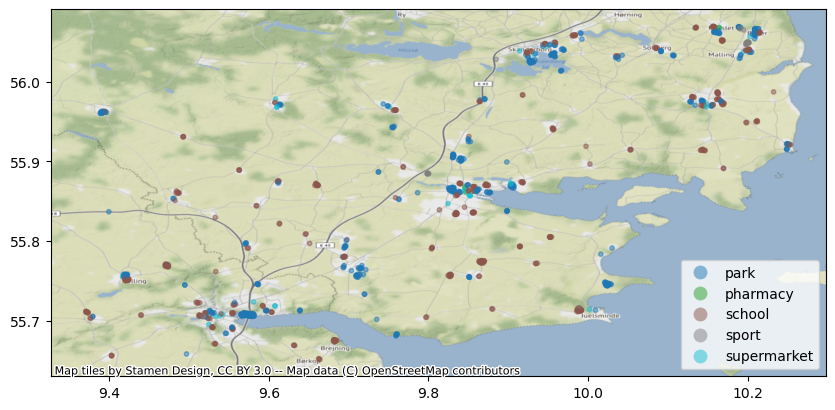

In [8]:
sample_df = h3_df.sample(1000) #df.sample(100)
sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
# geopandas.points_from_xy(x, y, z=None, crs=None)
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='category', categorical=True, legend=True, markersize=10, alpha=0.5)

# denmark
#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)

# middle east
#plt.ylim(12.391681,12.737388)
#plt.xlim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")

/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_35605/2157684182.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = origins[['h3_index','hex_type']].append(h3_df[['h3_index','hex_type']])


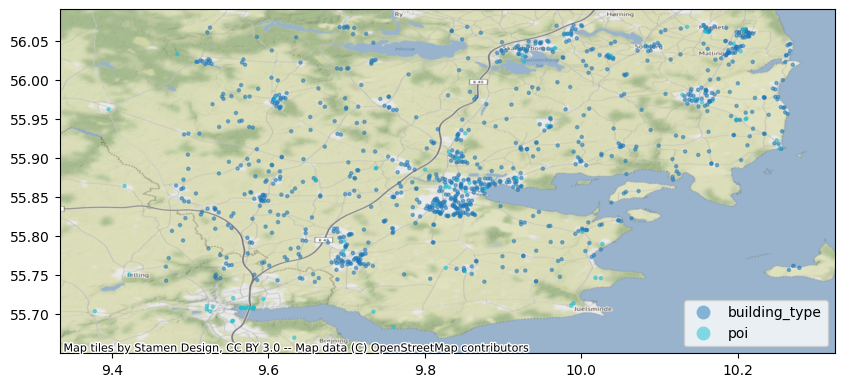

In [9]:
h3_df['hex_type'] = 'poi'
origins = pd.read_csv(h3_csv)
origins = origins[origins['residential_bool']==1]
origins['hex_type'] = 'building_type'
combined = origins[['h3_index','hex_type']].append(h3_df[['h3_index','hex_type']])

sample_df = combined.sample(1000) #df.sample(100)
sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='hex_type', categorical=True, legend=True, markersize=5, alpha=0.5)

#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")

# Routing

In [ ]:
def routing(category_set, origins, destinations, num_origins):
    # get residential origins
    origins = list(origins[origins['residential_bool']==1].sample(num_origins)['h3_index'])

    mins={}
    category_travel_time_means = {}
    for c in category_set:
        destinations = list(h3_df[h3_df['category']==c]['h3_index'])
        ds = graph.matrix_distance(origins=origins, destinations=destinations, dynamic_infinity=True)

        # they might be different lengths, so we can't use a df
        mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}
        category_travel_time_means[c] = np.nanmean(list(mins[c].values()))

    return category_travel_time_means, mins

In [12]:
# for testing
category_set = ['pharmacy','supermarket','sport', 'school']
category_set = ['pharmacy', 'supermarket']

#category_set = set(['supermarket'])

origins = pd.read_csv(h3_csv)
origins = list(origins[origins['residential_bool']==1].sample(1000)['h3_index'])

mins={}
category_travel_time_means = {}
for c in category_set:
    print(c)
    destinations = list(h3_df[h3_df['category']==c]['h3_index'])
    ds = graph.matrix_distance(origins=origins, destinations=destinations, dynamic_infinity=True)

    # they might be different lengths, so we can't use a df
    mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}
    category_travel_time_means[c] = np.nanmean(list(mins[c].values()))

pharmacy
matrix distance computed for 913 origins - got 912 results
supermarket


/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_35605/2962916107.py:18: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}


matrix distance computed for 913 origins - got 912 results


In [13]:
category_travel_time_means

{'pharmacy': 25.145229415268325, 'supermarket': 13.674560099432378}

In [47]:
category_travel_time_means

{'pharmacy': 7.524662246904987,
 'supermarket': 4.41982164818431,
 'sport': 7.792609982534439,
 'school': 4.3095285151723655}

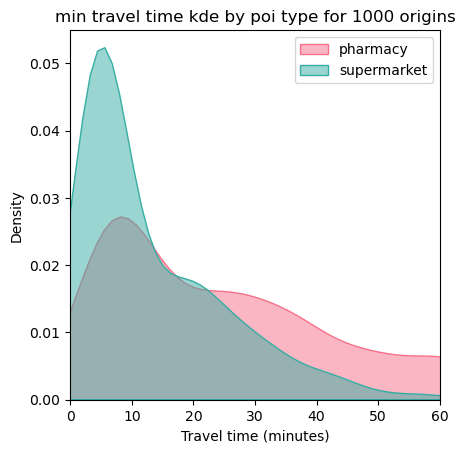

In [15]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Travel time (minutes)")
ax.set_title(f"min travel time kde by poi type for {len(origins)} origins")
ax.set_box_aspect(1)
ax.set_xlim(0, 60)
#ax.set_ylim(0, 0.06)

for i,c in enumerate(category_set):
    sns.kdeplot(list(mins[c].values()), color=colors[i], fill=True, alpha=0.5, ax=ax)

# Add a legend
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/kde_pois_{len(origins)}_origins.png', dpi=300)

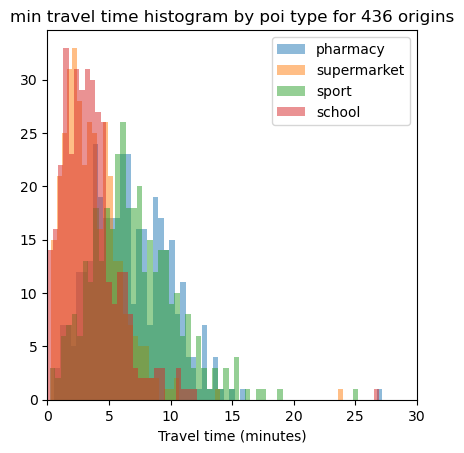

In [65]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Travel time (minutes)")
ax.set_title(f"min travel time histogram by poi type for {len(origins)} origins")
ax.set_box_aspect(1)
ax.set_xlim(0, 30)
#ax.set_ylim(0, 0.06)

for i,c in enumerate(category_set):
    plt.hist(list(mins[c].values()), alpha=0.5, bins=300)

# Add a legend
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/hist_pois{len(origins)}_origins.png', dpi=300)

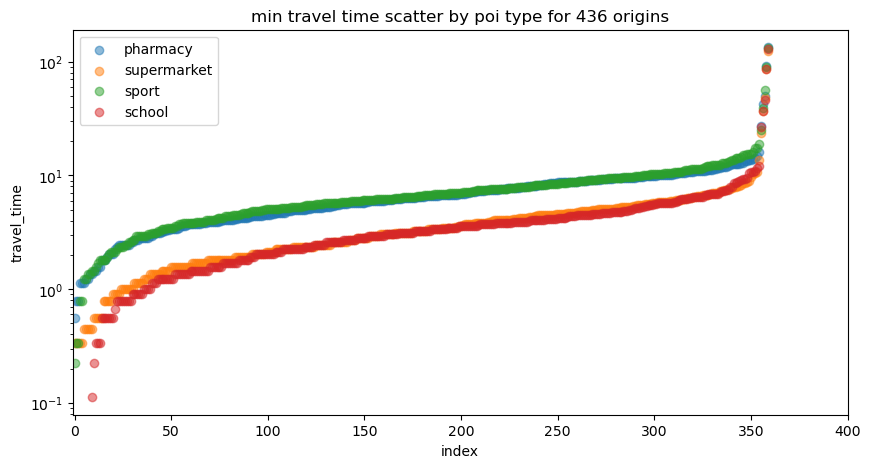

In [63]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_xlabel("index")
ax.set_ylabel("travel_time")
ax.set_title(f"min travel time scatter by poi type for {len(origins)} origins")
#ax.set_box_aspect(1)
ax.set_xlim(-1, 400)
ax.set_ylim(0, 0.06)

for i,c in enumerate(category_set):
    plt.scatter(range(len(mins[c].values())), np.sort(np.array(mins[c].values(), dtype=np.float64)), alpha=0.5)

# Add a legend
plt.yscale('log')
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/scatter_pois{len(origins)}_origins.png', dpi=300)

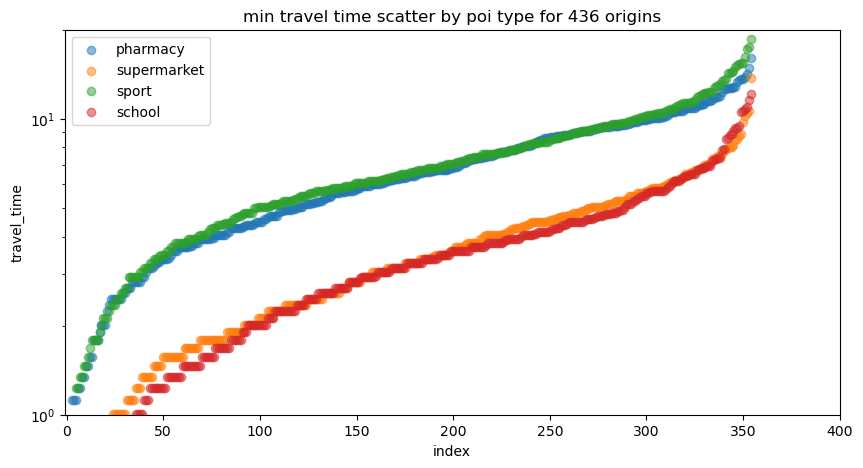

In [67]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_xlabel("index")
ax.set_ylabel("travel_time")
ax.set_title(f"min travel time scatter by poi type for {len(origins)} origins")
#ax.set_box_aspect(1)
ax.set_xlim(-1, 400)
ax.set_ylim(1, 20)

for i,c in enumerate(category_set):
    plt.scatter(range(len(mins[c].values())), sorted(list(mins[c].values())), alpha=0.5)

# Add a legend
plt.yscale('log')
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/scatter_pois{len(origins)}_origins.png', dpi=300)

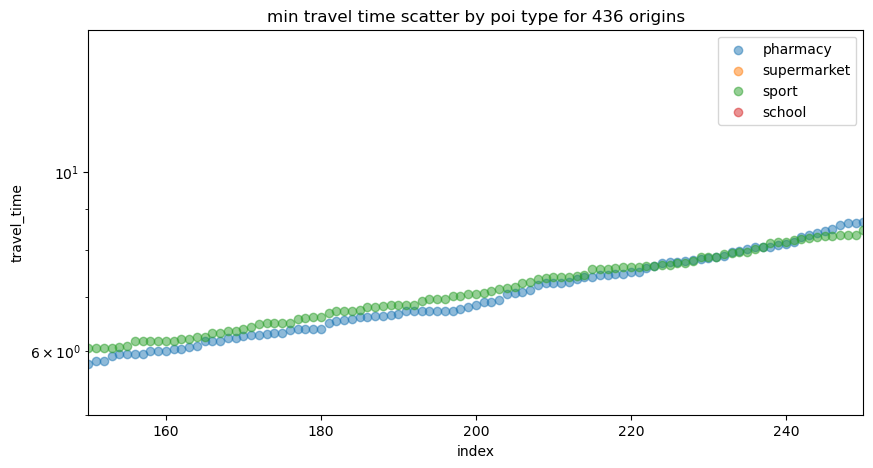

In [66]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_xlabel("index")
ax.set_ylabel("travel_time")
ax.set_title(f"min travel time scatter by poi type for {len(origins)} origins")
#ax.set_box_aspect(1)
ax.set_xlim(150, 250)
ax.set_ylim(5, 15)

for i,c in enumerate(category_set):
    plt.scatter(range(len(mins[c].values())), np.sort(np.array(mins[c].values(), dtype=np.float64)), alpha=0.5)

# Add a legend
plt.yscale('log')
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/scatter_pois{len(origins)}_origins.png', dpi=300)

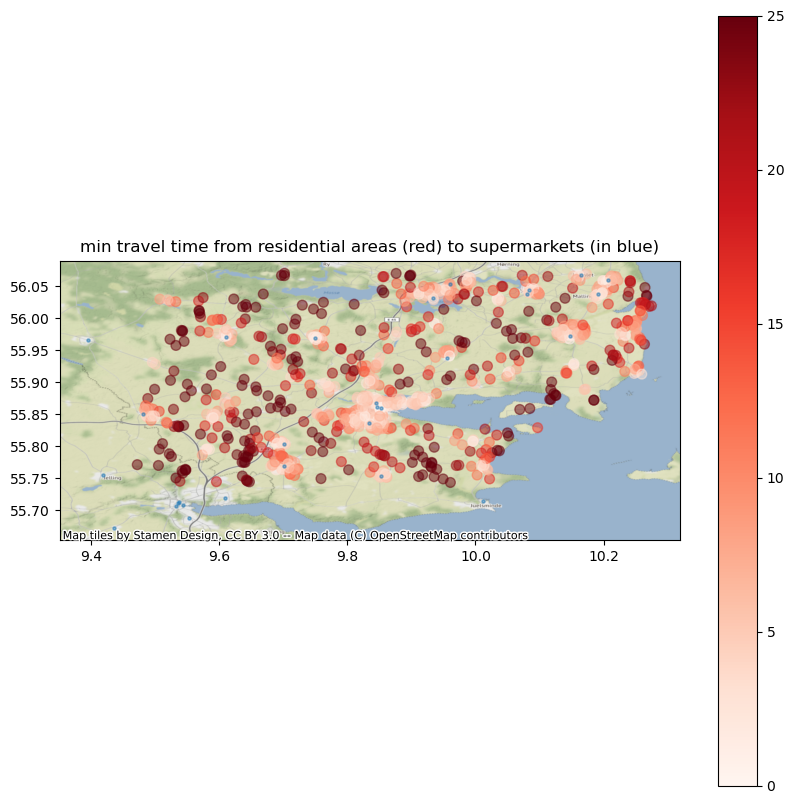

In [16]:
# plot travel time on top of poi points
plot_df = pd.DataFrame([(p,k,v) for p in mins.keys() for k,v in mins[p].items()],
                        columns = ['poi_type','h3_index','mean_dist'])
plot_df = plot_df[plot_df['poi_type']=='supermarket']
plot_df[['y','x']] = list(plot_df['h3_index'].apply(h3.h3_to_geo))
    # Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(plot_df, geometry=gpd.points_from_xy(plot_df.x, plot_df.y))

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, column='mean_dist', categorical=False,
            legend=True, markersize=50, alpha=0.5, cmap='Reds',
            vmin=0, vmax=25)

#plot poi points
poi_df = h3_df[h3_df['category']=='pharmacy'].copy()
poi_df[['y','x']] = list(poi_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.x, poi_df.y))

# Show the GeoPandas DataFrame
gdf.plot(ax=ax, markersize=5, alpha=0.5)


#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)
plt.title("min travel time from residential areas (red) to supermarkets (in blue)")
cx.add_basemap(ax = ax, crs="EPSG:4326")

#plt.savefig('figures/supermarkets_1000.png', dpi=300)

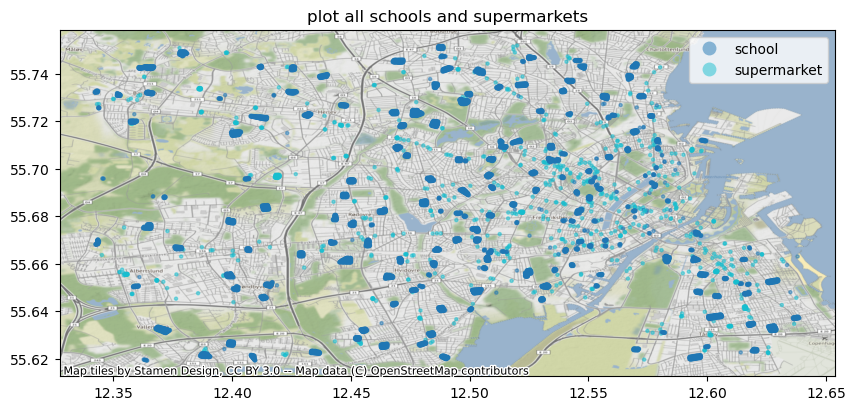

In [70]:
fig, ax = plt.subplots(figsize=(10,10))

#plot poi points
poi_df = h3_df[h3_df['category'].isin(['school','supermarket'])].copy()
poi_df[['y','x']] = list(poi_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.x, poi_df.y))

# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='category', markersize=5, alpha=0.5, legend=True)


#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)
plt.title("plot all schools and supermarkets")
cx.add_basemap(ax = ax, crs="EPSG:4326")

plt.savefig('figures/supermarkets_and_schools.png', dpi=300)

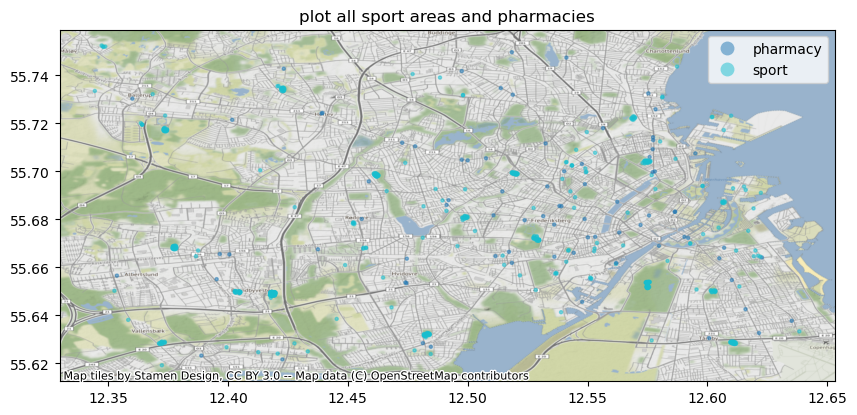

In [71]:
fig, ax = plt.subplots(figsize=(10,10))

#plot poi points
poi_df = h3_df[h3_df['category'].isin(['pharmacy','sport'])].copy()
poi_df[['y','x']] = list(poi_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.x, poi_df.y))

# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='category', markersize=5, alpha=0.5, legend=True)


#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)
plt.title("plot all sport areas and pharmacies")
cx.add_basemap(ax = ax, crs="EPSG:4326")

plt.savefig('figures/sport_and_pharmacy.png', dpi=300)

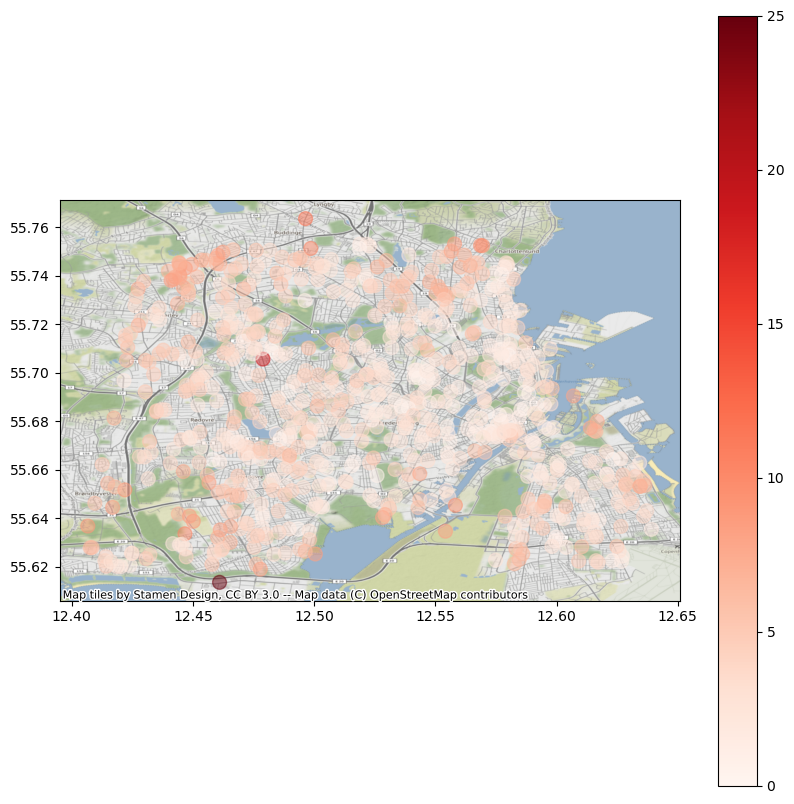

In [18]:
plot_df = pd.DataFrame([(k,v) for k,v in mins.items()], columns = ['h3_index','mean_dist'])
plot_hex_df(plot_df, markersize=100, color_column='mean_dist')